## Dynamics

Dynamics | $\partial_{\tau}x_i=$ |
| :--------: | :-------: |
Biochemical | $F -B x_i - R \sum_j A_{ij} x_i x_j$ |
Epidemics | $-B x_i + R \sum_j A_{ij} (1-x_i)x_j$ |
Population | $-B x_i^{b} + R \sum_j A_{ij} x_j^a$ |
Synchronization | $\omega_i + R \sum_j A_{ij} \sin(x_j-x_i)$ |

In [1]:
%load_ext autoreload
%autoreload 2

## Importing

In [2]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [3]:
from utils.utils import *
import optuna
from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend
from experiments.experiments_gkan import ExperimentsGKAN
from experiments.experiments_mpnn import ExperimentsMPNN
from train_and_eval import eval_model
import sympytorch

storage = JournalStorage(JournalFileBackend("optuna_journal_storage.log"))

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [4]:
import random

def set_pytorch_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    torch.use_deterministic_algorithms(True)
set_pytorch_seed(0)

In [5]:
# config = load_config("./configs/config_pred_deriv/config_real_epid_mpnn.yml")
# config['patience'] = 450
# exp = ExperimentsMPNN(
#     config=config,
#     n_trials=3,
#     study_name="test_mult_2"
# )

In [6]:
# exp.run()

In [7]:
# config = load_config("./configs/config_pred_deriv/config_ic1/config_population.yml")
# # config['t_span'] = [0, 1]
# exp = ExperimentsGKAN(
#     config=config,
#     n_trials=1,
#     study_name="test_mult_10",
#     snr_db=20
# )

In [8]:
# data = exp.training_set.raw_data_sampled[0].detach().cpu().numpy()
# plt.plot(data[:, 30, :])

In [9]:
# exp.training_set[0].y

In [10]:
# exp.epochs = 10
# exp.run()

In [11]:
# config_pop = load_config("./configs/config_pred_deriv/config_ic1/config_population_mpnn.yml")
# # config_pop["t_eval_steps"] = 1000
# # config_pop["t_span"] = [0, 10]

# exp = ExperimentsMPNN(
#     config=config_pop,
#     n_trials=1,
#     study_name='test_mult_3'
# )

In [12]:
# data = exp.training_set.raw_data_sampled[0].detach().cpu().numpy()
# plt.plot(data[:, 6, :])

In [13]:
# exp.training_set.raw_data_sampled.min()

In [14]:
# exp.epochs = 10
# exp.run()

## Utils

In [5]:
from models.utils.MPNN import MPNN
from models.baseline.MPNN_ODE import MPNN_ODE
from train_and_eval import eval_model
from datasets.SyntheticData import SyntheticData
from sympy import symbols, sin, summation, simplify
import networkx as nx
from torch_geometric.utils import from_networkx
from utils.utils import integrate
from torch_geometric.data import Data
from models.kan.KAN import KAN
from models.GKAN_ODE import GKAN_ODE

import optuna

import warnings
warnings.filterwarnings("ignore")

In [28]:
from sympy import latex
from torch.utils.data import DataLoader

def get_model(g, h, message_passing=True, include_time=False, atol=1e-5, rtol=1e-5, integration_method = 'scipy_solver'):
    conv = MPNN(
        g_net = g,
        h_net = h, 
        message_passing=message_passing,
        include_time=include_time
    )
    
    symb = MPNN_ODE(
        conv=conv,
        model_path="./saved_models_optuna/tmp_symb",
        adjoint=True,
        integration_method=integration_method,
        atol=atol,
        rtol=rtol
    )
    
    symb = symb.eval()
    return symb


def make_callable(expr):
    free_syms = expr.free_symbols
    if not free_syms:
        # Expression is constant
        const_value = float(expr)
        return lambda x: torch.full((x.shape[0], 1), const_value, dtype=x.dtype, device=x.device)

    sym_module = sympytorch.SymPyModule(expressions=[expr])
    syms = {str(s) for s in free_syms}
    if {'x_i', 'x_j'} <= syms:
        return lambda x: sym_module(x_i=x[:, 0], x_j=x[:, 1])
    elif 'x_i' in syms:
        return lambda x: sym_module(x_i=x[:, 0])
    elif 'x_j' in syms:
        return lambda x: sym_module(x_j=x[:, 1])
    else:
        raise ValueError(f"Unexpected symbols in expression: {free_syms}")


def get_symb_test_error(g_symb, h_symb, test_set, message_passing=False, include_time=False, atol=1e-5, rtol=1e-5, scaler = None, inverse_scale=False, method='scipy_solver', 
                        is_symb = True):
    
    if is_symb:
        if isinstance(g_symb, int):
            g_symb = sp.sympify(g_symb)
            
        if isinstance(h_symb, int):
            h_symb = sp.sympify(h_symb)

        g_symb = make_callable(g_symb)
        h_symb = make_callable(h_symb)
    
    test_losses = []
    
    for ts in test_set:
        symb = get_model(
            g=g_symb,
            h=h_symb,
            message_passing=message_passing,
            include_time=include_time,
            atol=atol,
            rtol=rtol,
            integration_method=method
        )
        
        collate_fn = lambda samples_list: samples_list
        test_loader = DataLoader(ts, batch_size=len(ts), shuffle=True, collate_fn=collate_fn)
        
        test_loss = eval_model(
            model=symb,
            valid_loader=test_loader,
            criterion=torch.nn.L1Loss(),
            scaler=scaler,
            inverse_scale=inverse_scale,
            pred_deriv=False
        )
        
        test_losses.append(test_loss)
    
    return test_losses



def get_test_set(dynamics, device='cuda', input_range=(0, 1), t_span = (0, 1), **integration_kwargs):
    seeds = [12345, 67890, 111213]
    
    graphs = [
        nx.barabasi_albert_graph(70, 3, seed=seeds[0]),      
        nx.watts_strogatz_graph(50, 6, 0.3, seed=seeds[1]),  
        nx.erdos_renyi_graph(100, 0.05, seed=seeds[2])        
    ]
    
    test_set = []
    for i, graph in enumerate(graphs):
        snapshots = integrate_test_set(
            graph=graph,
            dynamics=dynamics,
            seed=seeds[i],
            device=device,
            input_range=input_range,
            t_span=t_span,
            **integration_kwargs
        )
        test_set.append(snapshots)
    
    return test_set
    


def integrate_test_set(graph, dynamics, seed=12345, device='cuda', input_range = (0, 1), t_span = (0, 1), **integration_kwargs):
    # graph = nx.barabasi_albert_graph(100, 3, seed=seed)
    edge_index = from_networkx(graph).edge_index
    edge_index = edge_index.to(torch.device(device))
    rng = np.random.default_rng(seed=seed)
    
    data, t = integrate(
        input_range=input_range,
        t_span = t_span,
        t_eval_steps=1000,
        dynamics=dynamics,
        device=device,
        graph=graph,
        rng = rng,
        **integration_kwargs
    )
    
    snapshot = Data(
        x = data[0].unsqueeze(0),
        y = data[1:],
        edge_index=edge_index,
        edge_attr=None,
        t_span = t
    )
    
    return [snapshot]


def build_model_from_file(model_path, message_passing, include_time, method='dopri5', adjoint=False, atol=1e-5, rtol=1e-5):
    best_params_file = f"{model_path}/best_params.json"
    best_state_path = f"{model_path}/gkan/state_dict.pth"
    
    with open(best_params_file, 'r') as f:
        best_hyperparams = json.load(f)
    
    # g_net
    g_net = KAN(
        layers_hidden=[2, best_hyperparams['hidden_dim_g_net'], 1],
        grid_size=best_hyperparams['grid_size_g_net'],
        spline_order=best_hyperparams['spline_order_g_net'],
        grid_range=[-best_hyperparams['range_limit_g_net'], best_hyperparams['range_limit_g_net']],
        mu_1=best_hyperparams['mu_1_g_net'],
        mu_2=best_hyperparams['mu_2_g_net'],
        device='cuda',
        compute_mult=True,
        store_act=True
    )
    
    time_dim = 1 if include_time else 0
    in_dim_h = 2 if message_passing else 1
    in_dim_h += time_dim
    
    # h_net
    h_net = KAN(
        layers_hidden=[in_dim_h, best_hyperparams['hidden_dim_h_net'], 1],
        grid_size=best_hyperparams['grid_size_h_net'],
        spline_order=best_hyperparams['spline_order_h_net'],
        grid_range=[-best_hyperparams['range_limit_h_net'], best_hyperparams['range_limit_h_net']],
        mu_1=best_hyperparams['mu_1_h_net'],
        mu_2=best_hyperparams['mu_2_h_net'],
        device='cuda',
        compute_mult=True,
        store_act=True
    )
    
    gkan = MPNN(
        h_net=h_net,
        g_net=g_net,
        message_passing=message_passing,
        include_time=include_time
    )
    
    model = GKAN_ODE(
        conv=gkan,
        model_path='./saved_models_optuna/tmp',
        lmbd_g=best_hyperparams['lamb_g_net'],
        lmbd_h=best_hyperparams['lamb_h_net'],
        integration_method=method,
        adjoint=adjoint,
        atol=atol,
        rtol=rtol
    )
    
    model = model.to(torch.device('cuda'))
    model.load_state_dict(torch.load(best_state_path, weights_only=False, map_location=torch.device('cuda')))
    
    return model


def valid_symb_model(
    config,
    model_path_gkan,
    device='cuda',
    atol=1e-5,
    rtol=1e-5,
    method='dopri5',
    black_box_fitting=True,
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    sample_size=10000
):
    
    seed = 9999
    graph = nx.barabasi_albert_graph(100, 3, seed=seed)

    # Prepare validation/test set
    valid_set = integrate_test_set(
        graph=graph,
        dynamics=config['name'],
        seed=seed,
        device=device,
        input_range=config['input_range'],
        t_span=(0, 1),
        **config['integration_kwargs']
    )

    # Helper to compute validation loss
    def evaluate_model(g_symb, h_symb, is_symb=True):
        errs = get_symb_test_error(
            g_symb=g_symb,
            h_symb=h_symb,
            test_set=[valid_set],
            message_passing=False,
            include_time=False,
            method=method,
            atol=atol,
            rtol=rtol,
            is_symb=is_symb
        )
        return errs[0]

    # Helper to fit model for current config
    def fit_single_model(param1, param2):
        if black_box_fitting:
            print(f"Fitting black-box model with {param1} and {param2} iterations")
            pysr_model = lambda: get_pysr_model(model_selection=param1, n_iterations=param2)
            _, g_symb, h_symb = fit_black_box_from_kan(
                n_g_hidden_layers=n_g_hidden_layers,
                n_h_hidden_layers=n_h_hidden_layers,
                device=device,
                model_path=model_path_gkan,
                pysr_model=pysr_model,
                sample_size=sample_size,
                theta=-np.inf,
                message_passing=False,
                verbose=False
            )
        else:
            print(f"Fitting symbolic model with {param1} and theta {param2}")
            _, g_symb, h_symb = fit_model(
                n_g_hidden_layers=n_g_hidden_layers,
                n_h_hidden_layers=n_h_hidden_layers,
                model_path=model_path_gkan,
                theta=param2,
                message_passing=False,
                include_time=False,
                sample_size=sample_size,
                sort_by=param1,
                verbose=False
            )
        return g_symb, h_symb

    # Define parameter grid
    param_grid = (
        (["score", "accuracy"], [50, 100, 200]) if black_box_fitting
        else (["score", "log_loss"], [0.01, 0.05, 0.1])
    )

    search_space = [(mod, val) for mod in param_grid[0] for val in param_grid[1]]
    valid_losses = []

    for mod, val in search_space:
        g_symb, h_symb = fit_single_model(mod, val)
        try:
            loss = evaluate_model(g_symb, h_symb)
        except AssertionError:
            loss = 1e8
        valid_losses.append({'model_selection': mod, 'param': val, 'valid_loss': loss})

    # Select best performing configuration
    best = min(valid_losses, key=lambda x: x['valid_loss'])

    # Final refit with best config
    print(f"Refitting best model with {best}")
    if black_box_fitting:
        gkan_symb, symb_g, symb_h = fit_black_box_from_kan(
            model_path=model_path_gkan,
            n_g_hidden_layers=n_g_hidden_layers,
            n_h_hidden_layers=n_h_hidden_layers,
            device=device,
            theta=-np.inf,
            pysr_model=lambda: get_pysr_model(
                model_selection=best['model_selection'],
                n_iterations=best['param']
            ),
            sample_size=sample_size,
            message_passing=False,
            verbose=True,
            include_time=False
        )
    else:
        gkan_symb, symb_g, symb_h = fit_model(
            model_path=model_path_gkan,
            n_g_hidden_layers=n_g_hidden_layers,
            n_h_hidden_layers=n_h_hidden_layers,
            theta=best['param'],
            message_passing=False,
            include_time=False,
            sample_size=sample_size,
            sort_by=best['model_selection'],
            verbose=True
        )

    return gkan_symb, symb_g, symb_h


def post_process_gkan(
    config,
    model_path, 
    test_set, 
    device='cuda',
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    sample_size=10000,
    message_passing=False, 
    include_time=False,
    atol=1e-5,
    rtol=1e-5,
    method='dopri5',
    scaler=None,
    inverse_scale=False,
    adjoint=True,
    eval_model=True
):
    
    def print_symb_error(g_symb, h_symb, txt="symbolic formula", is_symb=True):
        try:
            test_losses_symb = get_symb_test_error(
                g_symb=g_symb,
                h_symb=h_symb,
                test_set=test_set,
                message_passing=message_passing,
                include_time=include_time,
                atol=atol,
                rtol=rtol,
                method=method,
                scaler=scaler,
                inverse_scale=inverse_scale,
                is_symb=is_symb
            )

            ts_mean = np.mean(test_losses_symb)
            ts_var = np.var(test_losses_symb)
            ts_std = np.std(test_losses_symb)
            
            print(f"Mean Test loss of {txt}: {ts_mean}")
            print(f"Var Test loss of {txt}: {ts_var}")
            print(f"Std Test loss of {txt}: {ts_std}")
        except AssertionError:
            print("Evaluation failed!")
        
    
    print("Black-Box fitting \n")
    bb_symb, bb_g_symb, bb_h_symb = valid_symb_model(
        config=config,
        model_path_gkan=f"{model_path}/gkan",
        device=device,
        atol=atol,
        rtol=rtol,
        method=method,
        black_box_fitting=True,
        n_g_hidden_layers=n_g_hidden_layers,
        n_h_hidden_layers=n_h_hidden_layers,
        sample_size = sample_size
    )
    
    print(latex(quantise(bb_symb)))
    print_symb_error(g_symb=bb_g_symb, h_symb=bb_h_symb)
    
    print("Spline-wise fitting\n")
    spline_symb, spl_g_symb, spl_h_symb = valid_symb_model(
        config=config,
        model_path_gkan=f"{model_path}/gkan",
        device=device,
        atol=atol,
        rtol=rtol,
        method=method,
        black_box_fitting=False,
        n_g_hidden_layers=n_g_hidden_layers,
        n_h_hidden_layers=n_h_hidden_layers,
        sample_size = sample_size
    )
    print(latex(quantise(spline_symb)))
    print_symb_error(g_symb=spl_g_symb, h_symb=spl_h_symb)
    
    
    if eval_model:
        print("Evaluate raw model\n")
        # Loading best model
        best_model = build_model_from_file(
            model_path=model_path,
            message_passing=message_passing,
            include_time=include_time,
            method=method,
            adjoint=adjoint,
            atol=atol,
            rtol=rtol
        )

        tot_params = sum(p.numel() for p in best_model.parameters() if p.requires_grad)
        print(f"Number of model's parameters: {tot_params}\n")

        best_model = best_model.eval()
        print_symb_error(
            g_symb=best_model.conv.model.g_net,
            h_symb=best_model.conv.model.h_net,
            txt="best model",
            is_symb=False
        )



def plot_predictions(y_true, y_pred, node_index = 0):
    plt.figure(figsize=(16, 8))
    plt.plot(y_true[:, node_index, :], label='y_true', marker='o')
    plt.plot(y_pred[:, node_index, :], label='y_pred', marker='o')
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.title(f'y_true vs y_pred for Node {node_index}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## LB losses


### Kuramoto

In [7]:
kur_config = load_config("./configs/config_pred_deriv/config_ic1/config_kuramoto.yml")

KUR = get_test_set(
    dynamics=kur_config['name'],
    device='cuda',
    input_range=kur_config['input_range'],
    **kur_config['integration_kwargs']    
)

g_symb = lambda x: torch.sin(x[:, 1] - x[:, 0]).unsqueeze(-1)
h_symb = lambda x: 2.0 + 0.5 * x[:, 1].unsqueeze(-1)

test_losses = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=KUR,
    message_passing=True,
    include_time=False,
    is_symb=False
)

ts_mean = np.mean(test_losses)
ts_var = np.var(test_losses)
ts_std = np.std(test_losses)

print(f"Mean Test loss of symbolic formula: {ts_mean}")
print(f"Var Test loss of symbolic formula: {ts_var}")
print(f"Std Test loss of symbolic formula: {ts_std}")



Mean Test loss of symbolic formula: 1.3504788815528931e-05
Var Test loss of symbolic formula: 1.314533673970284e-13
Std Test loss of symbolic formula: 3.625649836884809e-07


### Epidemics

In [8]:
epid_config = load_config("./configs/config_pred_deriv/config_ic1/config_epidemics.yml")

EPID = get_test_set(
    dynamics=epid_config['name'],
    device='cuda',
    input_range=epid_config['input_range'],
    **epid_config['integration_kwargs']    
)

g_symb = lambda x: 0.5*x[:, 1].unsqueeze(-1) * (1 - x[:, 0].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(1) - 0.5 * x[:, 0].unsqueeze(-1)

test_losses = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=EPID,
    message_passing=True,
    include_time=False,
    is_symb=False
)


ts_mean = np.mean(test_losses)
ts_var = np.var(test_losses)
ts_std = np.std(test_losses)

print(f"Mean Test loss of symbolic formula: {ts_mean}")
print(f"Var Test loss of symbolic formula: {ts_var}")
print(f"Std Test loss of symbolic formula: {ts_std}")


Mean Test loss of symbolic formula: 1.071706852447581e-06
Var Test loss of symbolic formula: 8.008373820613663e-14
Std Test loss of symbolic formula: 2.829907033917133e-07


### Population

In [9]:
pop_config = load_config("./configs/config_pred_deriv/config_ic1/config_population.yml")

POP = get_test_set(
    dynamics=pop_config['name'],
    device='cuda',
    input_range=pop_config['input_range'],
    **pop_config['integration_kwargs']
)

g_symb = lambda x: 0.2*torch.pow(x[:, 1].unsqueeze(-1), 3)
h_symb = lambda x: -0.5 * x[:, 0].unsqueeze(-1) + x[:, 1].unsqueeze(1) 

test_losses = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=POP,
    message_passing=True,
    include_time=False,
    is_symb=False
)

ts_mean = np.mean(test_losses)
ts_var = np.var(test_losses)
ts_std = np.std(test_losses)

print(f"Mean Test loss of symbolic formula: {ts_mean}")
print(f"Var Test loss of symbolic formula: {ts_var}")
print(f"Std Test loss of symbolic formula: {ts_std}")


Mean Test loss of symbolic formula: 3.735399635237021e-06
Var Test loss of symbolic formula: 4.746857081617248e-13
Std Test loss of symbolic formula: 6.889743886108719e-07


### Biochemical

In [10]:
bio_config = load_config("./configs/config_pred_deriv/config_ic1/config_biochemical.yml")

BIO = get_test_set(
    dynamics=bio_config['name'],
    device='cuda',
    input_range=bio_config['input_range'],
    **bio_config['integration_kwargs']    
)

g_symb = lambda x: (-0.5*x[:, 1] * x[:, 0]).unsqueeze(-1)
h_symb = lambda x: (1.0 - 0.5 * x[:, 0]).unsqueeze(-1)  + x[:, 1].unsqueeze(-1) 

test_losses = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=BIO,
    message_passing=True,
    include_time=False,
    is_symb=False
)

ts_mean = np.mean(test_losses)
ts_var = np.var(test_losses)
ts_std = np.std(test_losses)

print(f"Mean Test loss of symbolic formula: {ts_mean}")
print(f"Var Test loss of symbolic formula: {ts_var}")
print(f"Std Test loss of symbolic formula: {ts_std}")


Mean Test loss of symbolic formula: 1.2006473374034006e-06
Var Test loss of symbolic formula: 7.184599599254429e-14
Std Test loss of symbolic formula: 2.6804103415810103e-07


## Symb Reg

### Biochemical


#### IC=1

In [14]:
model_path_gkan = "./saved_models_optuna/model-biochemical-gkan/biochemical_gkan_ic1_s5_pd_mult_12/0"

post_process_gkan(
    config=bio_config,
    model_path=model_path_gkan,
    test_set=BIO,
    device='cuda',
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    sample_size=30000,
    message_passing=False,
    include_time=False,
    atol=1e-5,
    rtol=1e-5,
    method="dopri5"
)

Black-Box fitting 

Fitting black-box model with score and 50 iterations
Fitting black-box model with score and 100 iterations
Fitting black-box model with score and 200 iterations
Fitting black-box model with accuracy and 50 iterations
Fitting black-box model with accuracy and 100 iterations
Fitting black-box model with accuracy and 200 iterations
Refitting best model with {'model_selection': 'score', 'param': 50, 'valid_loss': 3.549701068550348e-05}
Fitting G_Net...
Execution time: 17.393635 seconds

Fitting H_Net...
Execution time: 19.248945 seconds
\sum_{j}(-0.5*x_i*x_j) - 0.5 x_{i} + 1.0
Mean Test loss of symbolic formula: 3.2913121685851365e-05
Var Test loss of symbolic formula: 3.9214064673506565e-12
Std Test loss of symbolic formula: 1.980254142111728e-06
Spline-wise fitting

Fitting symbolic model with score and theta 0.01
Fitting symbolic model with score and theta 0.05
Fitting symbolic model with score and theta 0.1
Fitting symbolic model with log_loss and theta 0.01
Fitting

#### SNR

In [21]:
model_paths_gkan = [
    "./saved_models_optuna/model-biochemical-gkan/biochemical_gkan_ic1_s5_pd_mult_noise_70db_2/0",
    "./saved_models_optuna/model-biochemical-gkan/biochemical_gkan_ic1_s5_pd_mult_noise_50db_2/0",
    "./saved_models_optuna/model-biochemical-gkan/biochemical_gkan_ic1_s5_pd_mult_noise_20db_2/0"
]

for model_path in model_paths_gkan:
    print(model_path)
    
    post_process_gkan(
        config=bio_config,
        model_path=model_path,
        test_set=BIO,
        device='cuda',
        n_g_hidden_layers=2,
        n_h_hidden_layers=2,
        sample_size=10000,
        message_passing=False,
        include_time=False,
        atol=1e-5,
        rtol=1e-5,
        method="dopri5",
        eval_model=False
    )


./saved_models_optuna/model-biochemical-gkan/biochemical_gkan_ic1_s5_pd_mult_noise_70db_2/0
Black-Box fitting 

Fitting black-box model with score and 50 iterations
Fitting black-box model with score and 100 iterations
Fitting black-box model with score and 200 iterations
Fitting black-box model with accuracy and 50 iterations
Fitting black-box model with accuracy and 100 iterations
Fitting black-box model with accuracy and 200 iterations
Refitting best model with {'model_selection': 'score', 'param': 50, 'valid_loss': 0.0017313702264800668}
Fitting G_Net...
Execution time: 9.212349 seconds

Fitting H_Net...
Execution time: 10.594127 seconds
\sum_{j}(-0.5*x_i*x_j) + \log{\left(2.63 - x_{i} \right)}
Mean Test loss of symbolic formula: 0.00168048485647887
Var Test loss of symbolic formula: 3.0966358974741028e-09
Std Test loss of symbolic formula: 5.56474248952645e-05
Spline-wise fitting

Fitting symbolic model with score and theta 0.01
Pruning node (0,0)
Fitting symbolic model with score

### Kuramoto

#### IC=1

In [31]:
model_path_gkan = "./saved_models_optuna/model-kuramoto-gkan/kuramoto_gkan_ic1_s5_pd_mult_12/0"

post_process_gkan(
    config=kur_config,
    model_path=model_path_gkan,
    test_set=KUR,
    device='cuda',
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    sample_size=10000,
    message_passing=False,
    include_time=False,
    atol=1e-5,
    rtol=1e-5,
    method="dopri5"
)

Black-Box fitting 

Fitting black-box model with score and 50 iterations
Fitting black-box model with score and 100 iterations
Fitting black-box model with score and 200 iterations
Fitting black-box model with accuracy and 50 iterations
Fitting black-box model with accuracy and 100 iterations
Fitting black-box model with accuracy and 200 iterations
Refitting best model with {'model_selection': 'accuracy', 'param': 100, 'valid_loss': 0.00041059116483666003}
Fitting G_Net...
Execution time: 22.446857 seconds

Fitting H_Net...
Execution time: 24.850279 seconds
\sum_{j}(-0.52*sin(x_i - x_j)) + 2.0
Mean Test loss of symbolic formula: 0.012538877005378405
Var Test loss of symbolic formula: 7.523174971765879e-07
Std Test loss of symbolic formula: 0.0008673623793874092
Spline-wise fitting

Fitting symbolic model with score and theta 0.01
Pruning node (0,0)
Pruning node (0,1)
Pruning node (0,3)
Pruning node (0,4)
Pruning node (0,0)
Pruning node (0,1)
Pruning node (0,3)
Pruning node (0,4)
Prunin

#### SNR

In [32]:
model_paths_gkan = [
    "./saved_models_optuna/model-kuramoto-gkan/kuramoto_gkan_ic1_s5_pd_mult_noise_70db_2/0",
    "./saved_models_optuna/model-kuramoto-gkan/kuramoto_gkan_ic1_s5_pd_mult_noise_50db_2/0",
    "./saved_models_optuna/model-kuramoto-gkan/kuramoto_gkan_ic1_s5_pd_mult_noise_20db/0",
]

for model_path in model_paths_gkan:
    print(model_path)
    
    post_process_gkan(
        config=kur_config,
        model_path=model_path,
        test_set=KUR,
        device='cuda',
        n_g_hidden_layers=2,
        n_h_hidden_layers=2,
        sample_size=10000,
        message_passing=False,
        include_time=False,
        atol=1e-5,
        rtol=1e-5,
        method="dopri5",
        eval_model=False
    )

./saved_models_optuna/model-kuramoto-gkan/kuramoto_gkan_ic1_s5_pd_mult_noise_70db_2/0
Black-Box fitting 

Fitting black-box model with score and 50 iterations
Fitting black-box model with score and 100 iterations
Fitting black-box model with score and 200 iterations
Fitting black-box model with accuracy and 50 iterations
Fitting black-box model with accuracy and 100 iterations
Fitting black-box model with accuracy and 200 iterations
Refitting best model with {'model_selection': 'accuracy', 'param': 100, 'valid_loss': 0.007145709823817015}
Fitting G_Net...
Execution time: 19.059034 seconds

Fitting H_Net...
Execution time: 23.521774 seconds
\sum_{j}(-0.49*sin(x_i - x_j)) + 2.01
Mean Test loss of symbolic formula: 0.007131052669137716
Var Test loss of symbolic formula: 6.036935300456649e-08
Std Test loss of symbolic formula: 0.0002457017562097725
Spline-wise fitting

Fitting symbolic model with score and theta 0.01
Fitting symbolic model with score and theta 0.05
Fitting symbolic model w

### Epidemics

#### IC=1

In [19]:
model_path_gkan = "./saved_models_optuna/model-epidemics-gkan/epidemics_gkan_ic1_s5_pd_mult_12/0"

post_process_gkan(
    config=epid_config,
    model_path=model_path_gkan,
    test_set=EPID,
    device='cuda',
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    sample_size=10000,
    message_passing=False,
    include_time=False,
    atol=1e-5,
    rtol=1e-5,
    method="dopri5"
)

Black-Box fitting 

Fitting black-box model with score and 50 iterations
Fitting black-box model with score and 100 iterations
Fitting black-box model with score and 200 iterations
Fitting black-box model with accuracy and 50 iterations
Fitting black-box model with accuracy and 100 iterations
Fitting black-box model with accuracy and 200 iterations
Refitting best model with {'model_selection': 'score', 'param': 50, 'valid_loss': 3.765320434467867e-05}
Fitting G_Net...
Execution time: 10.544345 seconds

Fitting H_Net...
Execution time: 10.334455 seconds
\sum_{j}(x_j*(0.5 - 0.5*x_i)) - 0.5 x_{i}
Mean Test loss of symbolic formula: 3.22361441552251e-05
Var Test loss of symbolic formula: 2.1891731062645337e-11
Std Test loss of symbolic formula: 4.678860017423618e-06
Spline-wise fitting

Fitting symbolic model with score and theta 0.01
Pruning node (0,1)
Pruning node (0,2)
Fitting symbolic model with score and theta 0.05
Pruning node (0,1)
Pruning node (0,2)
Fitting symbolic model with scor

#### SNR

In [23]:
model_paths_gkan = [
    "./saved_models_optuna/model-epidemics-gkan/epidemics_gkan_ic1_s5_pd_mult_noise_70db_2/0",
    "./saved_models_optuna/model-epidemics-gkan/epidemics_gkan_ic1_s5_pd_mult_noise_50db_2/0",
    "./saved_models_optuna/model-epidemics-gkan/epidemics_gkan_ic1_s5_pd_mult_noise_20db_2/0",
]

for model_path in model_paths_gkan:
    print(model_path)
    post_process_gkan(
        config=epid_config,
        model_path=model_path,
        test_set=EPID,
        device='cuda',
        n_g_hidden_layers=2,
        n_h_hidden_layers=2,
        sample_size=10000,
        message_passing=False,
        include_time=False,
        atol=1e-5,
        rtol=1e-5,
        method="dopri5"
    )


./saved_models_optuna/model-epidemics-gkan/epidemics_gkan_ic1_s5_pd_mult_noise_70db_2/0
Black-Box fitting 

Fitting black-box model with score and 50 iterations
Fitting black-box model with score and 100 iterations
Fitting black-box model with score and 200 iterations
Fitting black-box model with accuracy and 50 iterations
Fitting black-box model with accuracy and 100 iterations
Fitting black-box model with accuracy and 200 iterations
Refitting best model with {'model_selection': 'score', 'param': 50, 'valid_loss': 0.002244098810479045}
Fitting G_Net...
Execution time: 11.355172 seconds

Fitting H_Net...
Execution time: 10.227076 seconds
\sum_{j}(x_j*(0.51 - 0.51*x_i)) - 0.39 x_{i} - 0.06
Mean Test loss of symbolic formula: 0.002354982541874051
Var Test loss of symbolic formula: 1.0752977480680034e-07
Std Test loss of symbolic formula: 0.0003279173292261334
Spline-wise fitting

Fitting symbolic model with score and theta 0.01
Pruning node (0,1)
Pruning node (0,2)
Pruning node (0,3)
Fit

### Population

#### IC=1

In [29]:
model_path_gkan = "./saved_models_optuna/model-population-gkan/population_gkan_ic1_s5_pd_mult_12/0"

post_process_gkan(
    config=pop_config,
    model_path=model_path_gkan,
    test_set=POP,
    device='cuda',
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    sample_size=10000,
    message_passing=False,
    include_time=False,
    atol=1e-5,
    rtol=1e-5,
    method="dopri5"
)

Black-Box fitting 

Fitting black-box model with score and 50 iterations
Fitting black-box model with score and 100 iterations
Fitting black-box model with score and 200 iterations
Fitting black-box model with accuracy and 50 iterations
Fitting black-box model with accuracy and 100 iterations
Fitting black-box model with accuracy and 200 iterations
Refitting best model with {'model_selection': 'score', 'param': 100, 'valid_loss': 1.8369477402302437e-05}
Fitting G_Net...
Execution time: 18.368421 seconds

Fitting H_Net...
Execution time: 18.789813 seconds
\sum_{j}(0.2*x_j**3) - 0.5 x_{i}
Mean Test loss of symbolic formula: 1.7581651263753884e-05
Var Test loss of symbolic formula: 2.584156024652137e-12
Std Test loss of symbolic formula: 1.6075310338068553e-06
Spline-wise fitting

Fitting symbolic model with score and theta 0.01
Pruning node (0,0)
Pruning node (0,2)
Pruning node (0,4)
Fitting symbolic model with score and theta 0.05
Pruning node (0,0)
Pruning node (0,2)
Pruning node (0,4)

#### SNR

In [24]:
model_paths_gkan = [
    "./saved_models_optuna/model-population-gkan/population_gkan_ic1_s5_pd_mult_noise_70db_2/0",
    "./saved_models_optuna/model-population-gkan/population_gkan_ic1_s5_pd_mult_noise_50db_2/0",
    # "./saved_models_optuna/model-population-gkan/population_gkan_ic1_s5_pd_mult_noise_20db_2/0",
]

for model_path in model_paths_gkan:
    print(model_path)
    post_process_gkan(
        config=pop_config,
        model_path=model_path,
        test_set=POP,
        device='cuda',
        n_g_hidden_layers=2,
        n_h_hidden_layers=2,
        sample_size=10000,
        message_passing=False,
        include_time=False,
        atol=1e-5,
        rtol=1e-5,
        method="dopri5",
        eval_model=False
    )

./saved_models_optuna/model-population-gkan/population_gkan_ic1_s5_pd_mult_noise_70db_2/0
Black-Box fitting 

Fitting black-box model with score and 50 iterations
Fitting black-box model with score and 100 iterations
Fitting black-box model with score and 200 iterations
Fitting black-box model with accuracy and 50 iterations
Fitting black-box model with accuracy and 100 iterations
Fitting black-box model with accuracy and 200 iterations
Refitting best model with {'model_selection': 'score', 'param': 50, 'valid_loss': 100000000.0}
Fitting G_Net...
Execution time: 11.410990 seconds

Fitting H_Net...
Execution time: 11.822218 seconds
\sum_{j}(0.2*x_j**3) - 0.5 x_{i}
Mean Test loss of symbolic formula: 8.771742674677323e-05
Var Test loss of symbolic formula: 1.0174534376923578e-11
Std Test loss of symbolic formula: 3.1897545950940453e-06
Spline-wise fitting

Fitting symbolic model with score and theta 0.01
Fitting symbolic model with score and theta 0.05
Pruning node (0,0)
Pruning node (0,

KeyboardInterrupt: 

### Real Epid

In [55]:
model_path_gkan = "./saved_models_optuna/model-real-epid-gkan/real_epid_gkan_4/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb, symb_g, symb_h = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=10000,
    theta=-np.inf,
    message_passing=False
)

Fitting G_Net...
Execution time: 32.812989 seconds
Fitting H_Net...
Execution time: 17.956217 seconds


In [56]:
gkan_symb

\sum_{j}( log(12.5043577686824*x_i + 13.5111551375654)) + 2.4884284*sin(x_i) + 2.112076

In [57]:
symb_spline_wise, symb_g, symb_h = fit_model(
    n_h_hidden_layers=2,
    n_g_hidden_layers=2,
    model_path=model_path_gkan,
    theta=0.1,
    message_passing=False,
    include_time=False,
    sample_size=10000
)

Fitting G_Net...


Execution time: 10.827934 seconds

Fitting H_Net...
Execution time: 4.955698 seconds


## TSS Errors

In [7]:
def get_tss_test_error(
    text_sympy_mapping_g,
    text_sympy_mapping_h,
    row_means,
    test_set
):
    g_symb = sp.S(0)
    h_symb = sp.S(0)
            
    for symb_g in text_sympy_mapping_g.keys():
        g_symb += row_means[symb_g] * text_sympy_mapping_g[symb_g]
    for symb_h in text_sympy_mapping_h.keys():
        h_symb += row_means[symb_h] * text_sympy_mapping_h[symb_h]
    
    g_symb = make_callable(g_symb)
    h_symb = make_callable(h_symb)
    
    test_losses = get_symb_test_error(
        g_symb=g_symb,
        h_symb=h_symb,
        test_set=test_set,
        message_passing=False,
        include_time=False,
        method='dopri5',
        atol=1e-5,
        rtol=1e-5
    )
    
    ts_mean = np.mean(test_losses)
    ts_var = np.var(test_losses)
    ts_std = np.std(test_losses)

    print(f"Mean Test loss of symbolic formula: {ts_mean}")
    print(f"Var Test loss of symbolic formula: {ts_var}")
    print(f"Std Test loss of symbolic formula: {ts_std}")

### KUR

In [59]:
df = pd.read_csv("./saved_models_optuna/tss/Kuramoto-1/results_dim=0.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

In [60]:
x_i, x_j = sp.symbols('x_i x_j')

text_sympy_mapping_g = {
    "sinx1jMinusx1i": sp.sin(x_j - x_i)
}
text_sympy_mapping_h = {
    "constant": sp.S(1.0)
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=KUR
)


Mean Test loss of symbolic formula: 0.0002912786342979719
Var Test loss of symbolic formula: 4.206261141125669e-10
Std Test loss of symbolic formula: 2.0509171463337248e-05


#### 70 DB

In [61]:
df = pd.read_csv("./saved_models_optuna/tss/Kuramoto-1/results_dim=0_70_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)
row_means

0
NaN               0.000000
sinx1jMinusx1i    0.500084
constant          1.999299
dtype: float64

In [62]:
x_i, x_j = sp.symbols('x_i x_j')

text_sympy_mapping_g = {
    "sinx1jMinusx1i": sp.sin(x_j - x_i)
}
text_sympy_mapping_h = {
    "constant": sp.S(1.0)
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=KUR
)

Mean Test loss of symbolic formula: 0.00035186927804412943
Var Test loss of symbolic formula: 3.4495474563401334e-14
Std Test loss of symbolic formula: 1.85729573744736e-07


#### 50 DB

In [63]:
df = pd.read_csv("./saved_models_optuna/tss/Kuramoto-1/results_dim=0_50_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

x_i, x_j = sp.symbols('x_i x_j')

text_sympy_mapping_g = {
    "sinx1jMinusx1i": sp.sin(x_j - x_i)
}
text_sympy_mapping_h = {
    "fracx1": 1/ x_i
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=KUR
)

Mean Test loss of symbolic formula: 0.6032914121945699
Var Test loss of symbolic formula: 0.0009892931714156185
Std Test loss of symbolic formula: 0.03145303119598521


#### 20 DB

In [70]:
df = pd.read_csv("./saved_models_optuna/tss/Kuramoto-1/results_dim=0_20_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)
row_means

0
NaN                0.000000
x1iexpx1j          0.000338
fracx1jMinusx1i    0.026852
fracx1ix1j        -0.035464
x1ifracx1j        -0.020929
dtype: float64

In [ ]:
x_i, x_j = sp.symbols('x_i x_j')

text_sympy_mapping_g = {
    "x1iexpx1j": x_i * sp.exp(x_j),
    "fracx1jMinusx1i": 1/(x_j - x_i),
    "fracx1ix1j": 1/(x_i * x_j),
    "x1ifracx1j": x_i / x_j
}

text_sympy_mapping_h = {}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=KUR
)

### EPID

In [75]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Epidemics-1/results_dim=0.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN               0.000000
constant         -1.479146
expx1jMinusx1i    0.310919
dtype: float64

In [76]:
text_sympy_mapping_g = {
    "expx1jMinusx1i": sp.exp(x_j - x_i)
}

text_sympy_mapping_h = {
    "constant": sp.S(1.0)
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=EPID
)

Mean Test loss of symbolic formula: 0.13932317246993384
Var Test loss of symbolic formula: 0.0011257805640565567
Std Test loss of symbolic formula: 0.03355265360677985


#### 70 DB

In [77]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Epidemics-1/results_dim=0_70_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN         0.000000
x1x1x1     -1.319998
constant    0.645621
dtype: float64

In [79]:
text_sympy_mapping_g = {}

text_sympy_mapping_h = {
    "x1x1x1": x_i * x_i * x_i,
    "constant": sp.S(1.0)
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=EPID
)

Mean Test loss of symbolic formula: 0.06238254035512606
Var Test loss of symbolic formula: 6.161101675210123e-05
Std Test loss of symbolic formula: 0.007849268548858628


#### 50 DB

In [80]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Epidemics-1/results_dim=0_50_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN               0.000000
x1x1x1           -1.049246
expx1jMinusx1i    0.101428
dtype: float64

In [81]:
text_sympy_mapping_g = {
    "expx1jMinusx1i": sp.exp(x_j - x_i)
}

text_sympy_mapping_h = {
    "x1x1x1": x_i * x_i * x_i
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=EPID
)

Mean Test loss of symbolic formula: 0.021900850037733715
Var Test loss of symbolic formula: 4.893136437053426e-06
Std Test loss of symbolic formula: 0.0022120434980021134


#### 20 DB

In [82]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Epidemics-1/results_dim=0_20_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN                0.000000
fracx1ix1j         0.009380
x1ifracx1j         0.009147
fracx1j            0.000166
fracx1jMinusx1i    0.000093
dtype: float64

In [83]:
text_sympy_mapping_g = {
    "fracx1ix1j": 1/(x_i * x_j),
    "x1ifracx1j": x_i / x_j,
    "fracx1j": 1 / x_j,
    "fracx1jMinusx1i": 1/(x_j - x_i)
}

text_sympy_mapping_h = {}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=EPID
)

Mean Test loss of symbolic formula: 0.11705934256315231
Var Test loss of symbolic formula: 8.681066367199897e-06
Std Test loss of symbolic formula: 0.002946364941279321


### BIO

In [66]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Biochemical-1/results_dim=0.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN         0.000000
x1ix1j     -0.629935
constant    0.805864
dtype: float64

In [67]:
text_sympy_mapping_g = {
    "x1ix1j": x_i * x_j
}

text_sympy_mapping_h = {
    "constant": sp.S(1.0)
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=BIO
)

Mean Test loss of symbolic formula: 0.030168694754441578
Var Test loss of symbolic formula: 7.935192549003557e-07
Std Test loss of symbolic formula: 0.0008907969773749547


#### 70 DB

In [8]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Biochemical-1/results_dim=0_70_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN         0.000000
x1ix1j     -0.702419
constant    0.891260
dtype: float64

In [14]:
text_sympy_mapping_g = {
    "x1ix1j": x_i * x_j
}

text_sympy_mapping_h = {
    "constant": sp.S(1.0)
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=BIO
)

Mean Test loss of symbolic formula: 0.03311053911844889
Var Test loss of symbolic formula: 1.6136963490022263e-06
Std Test loss of symbolic formula: 0.0012703134845392402


#### 50 DB

In [15]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Biochemical-1/results_dim=0_50_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN       0.000000
x1x1     -1.690969
x1ix1j    0.935806
dtype: float64

In [ ]:
text_sympy_mapping_g = {
    "x1ix1j": x_i * x_j
}

text_sympy_mapping_h = {
    "x1x1": x_i * x_i
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=BIO
)

#### 20 DB

In [17]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Biochemical-1/results_dim=0_20_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN                0.000000
fracx1ix1j         0.000972
x1ifracx1j         0.000006
fracx1jMinusx1i    0.000711
dtype: float64

In [ ]:
text_sympy_mapping_g = {
    "fracx1ix1j": 1/(x_i * x_j),
    "x1ifracx1j": x_i / x_j,
    "fracx1jMinusx1i": 1/(x_j - x_i)
}

text_sympy_mapping_h = {}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=BIO
)

### POP

In [68]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Population-1/results_dim=0.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN         0.000000
constant   -0.026403
x1j         0.181286
sinx1j     -0.003445
dtype: float64

In [69]:
text_sympy_mapping_g = {
    "sinx1j": sp.sin(x_j),
    "x1j": x_j
}

text_sympy_mapping_h = {
    "constant": sp.S(1.0)
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=POP
)

Mean Test loss of symbolic formula: 0.127986046175162
Var Test loss of symbolic formula: 7.68135815102871e-05
Std Test loss of symbolic formula: 0.008764335771197217


#### 70 DB

In [19]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Population-1/results_dim=0_70_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN         0.000000
constant   -0.008463
x1j         0.049181
sinx1j      0.000000
dtype: float64

In [20]:
text_sympy_mapping_g = {
    "sinx1j": sp.sin(x_j),
    "x1j": x_j
}

text_sympy_mapping_h = {
    "constant": sp.S(1.0)
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=POP
)

Mean Test loss of symbolic formula: 0.0986446018020312
Var Test loss of symbolic formula: 9.624285289105355e-06
Std Test loss of symbolic formula: 0.0031023032232690207


#### 50 DB

In [21]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Population-1/results_dim=0_50_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN       0.000000
sinx1j   -0.437936
x1j       0.447304
dtype: float64

In [22]:
text_sympy_mapping_g = {
    "sinx1j": sp.sin(x_j),
    "x1j": x_j
}

text_sympy_mapping_h = {}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=POP
)

Mean Test loss of symbolic formula: 0.09825751930475235
Var Test loss of symbolic formula: 6.906377144659063e-06
Std Test loss of symbolic formula: 0.002627998695711066


#### 20 DB

In [23]:
x_i, x_j = sp.symbols('x_i x_j')

df = pd.read_csv("./saved_models_optuna/tss/Population-1/results_dim=0_20_db.csv", header=None)
df.set_index(0, inplace=True)
row_means = df.mean(axis=1)

row_means

0
NaN      0.000000
sinx1   -0.395957
x1x1     0.306063
dtype: float64

In [24]:
text_sympy_mapping_g = {}

text_sympy_mapping_h = {
    "sinx1": sp.sin(x_i),
    "x1x1": x_i * x_i
}

get_tss_test_error(
    text_sympy_mapping_g=text_sympy_mapping_g,
    text_sympy_mapping_h=text_sympy_mapping_h,
    row_means=row_means,
    test_set=POP
)

Mean Test loss of symbolic formula: 0.05001158267259598
Var Test loss of symbolic formula: 6.406370715870506e-06
Std Test loss of symbolic formula: 0.0025310809382298517


## Real Epid plots

In [26]:
from datasets.RealEpidemics import RealEpidemics

real_epid_data = RealEpidemics(
    root = './data_real_epid',
    name = 'RealEpid',
    predict_deriv=False,
    history=1,
    horizon=44
)

Processing...
Done!


Building the dataset...


In [33]:
x_i, x_j = sp.symbols('x_i x_j')

g_symb = 7.130 / (1 + sp.exp(- (x_j - x_i)))
h_symb = 0.074 * x_i

g_symb = make_callable(g_symb)
h_symb = make_callable(h_symb)

symb_model = get_model(
    g = g_symb,
    h = h_symb,
    message_passing=False,
    include_time=False,
    integration_method='dopri5'
)

y_true = real_epid_data[0].y.detach().cpu().numpy()
y_pred = symb_model(real_epid_data[0]).detach().cpu().numpy()

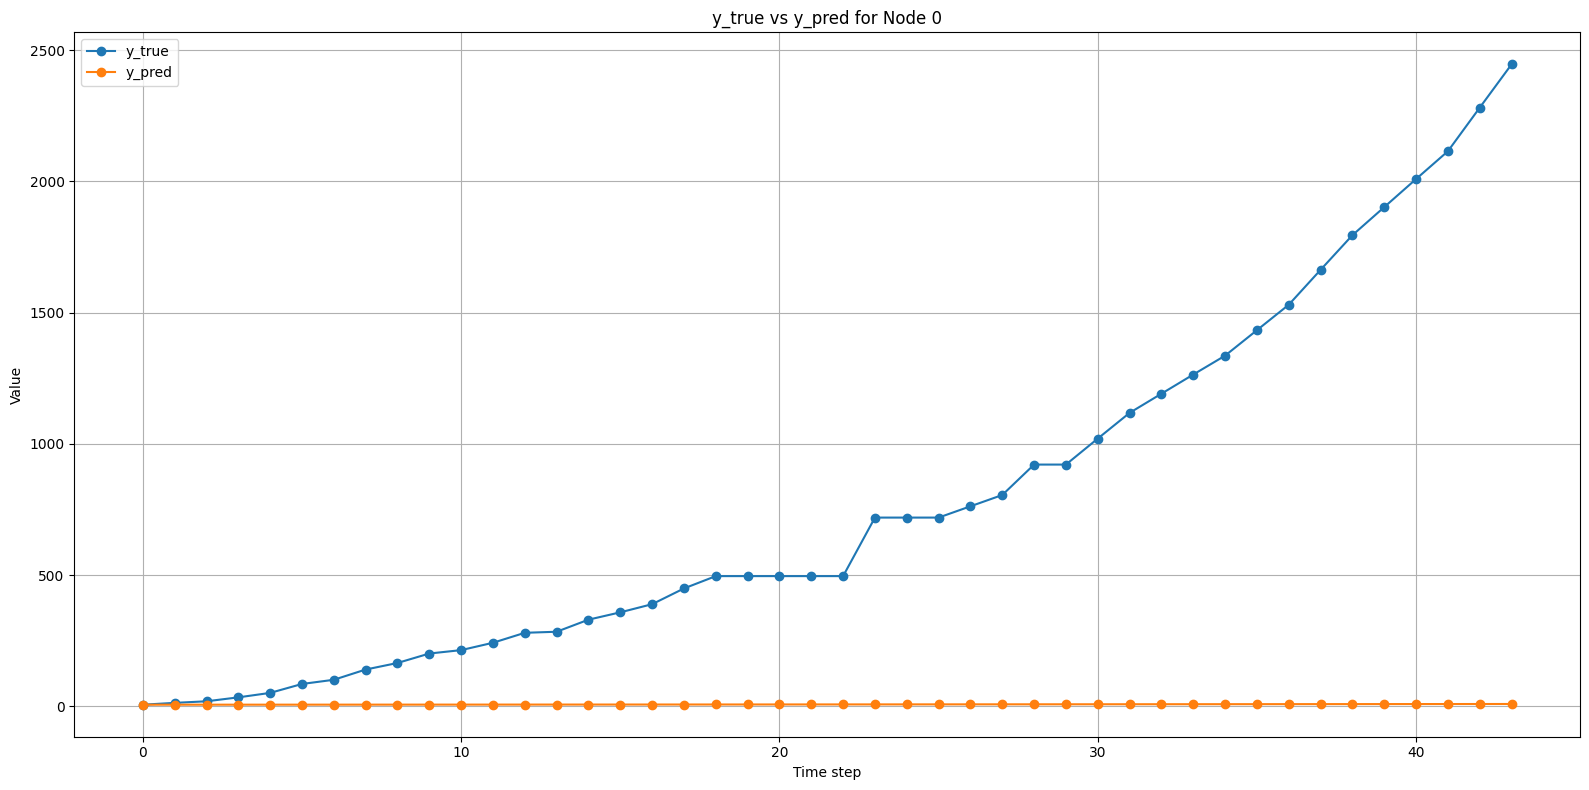

In [34]:
plot_predictions(
    y_true=y_true,
    y_pred=y_pred,
    node_index=0
)